# **Transfer Learning**

https://www.kaggle.com/code/adi160/cifar-10-keras-transfer-learning/notebook
https://medium.com/analytics-vidhya/cnn-transfer-learning-with-vgg16-using-keras-b0226c0805bd 
*   **What is Trasnfer Learning?**
*   **Why does transfer learning work so well ?**

**Transfer Learning: What?**
Use the pre-trained weights of an already trained model (one that has been trained on millions of images belonging to 1000’s of classes, on several high power GPU’s for several days) and use these already learned features to predict new classes.
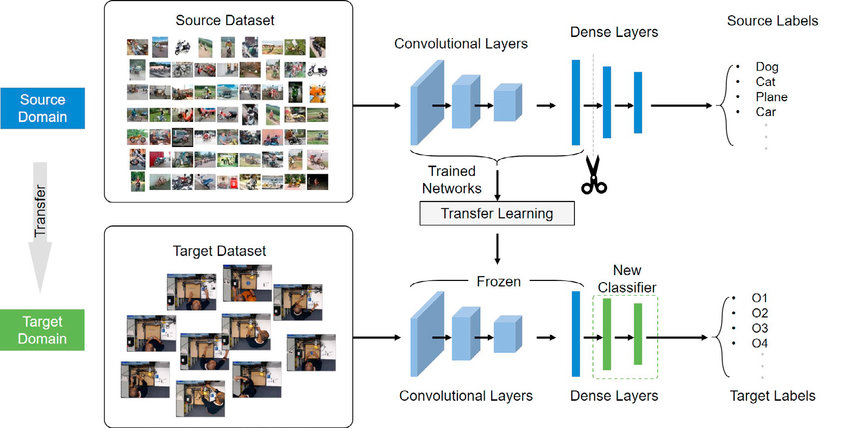







**Transfer Learning: Why?**

1.   No need of an extremely large dataset (Data is everywhere Data is Costly)
2.   Not much computational power is required.As we are using pre-trained weights and only have to learn the weights of the last few layers.
**Why Does Transfer Learning Work So Well ?**

Any deep learning models learns incrementally...

* The filters on the first few layers of the conv net learn to recognize colors and certain horizontal and vertical lines.
* The next few layers slowly learn to recognize trivial shapes using the lines and colors learnt in the previous layers.

* Then the next layers learn to recognize textures, then parts of objects like legs, eyes, nose etc.
* Finally the filters in the last layers get activated by whole objects like dogs, cars etc.

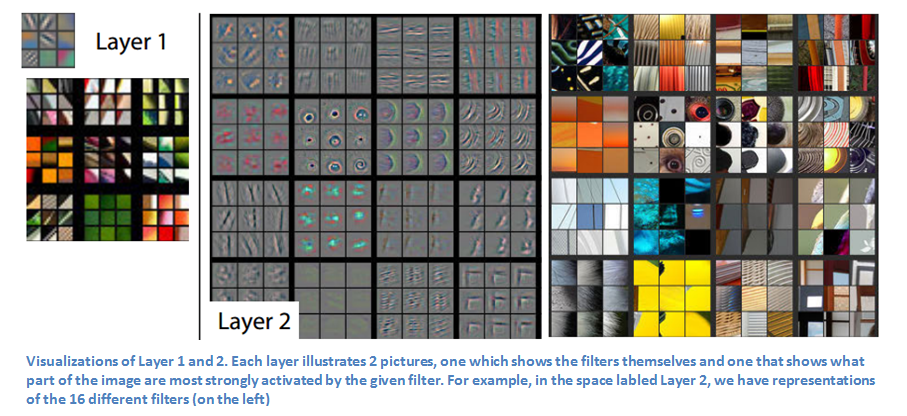

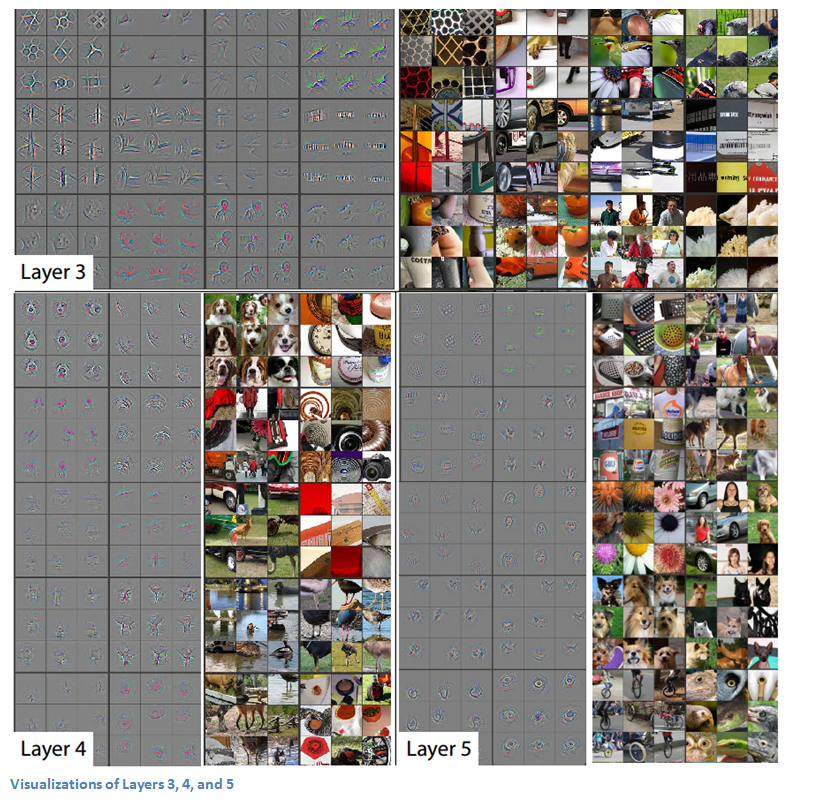




*   The pretrained networks on larger dataset (Imagenet) might have already learnt to recognize the trivial shapes and small parts of different objects in its initial layers.
*    By using a pretrained network to do transfer learning, few dense layers are getting added at the end of the pretrained network. 

**Steps to follow**

1. Initialize the pre-trained model (the model from which we want to learn)
2. Reshape the final layers to have the same number of outputs as the number of classed in the new dataset
3. Define which layers we want to update
4. Train on new dataset

*2 types:  feature extraction and fine tuning.*
                    
**Transfer Learning for Feature Extration**
Consider a CNN to recognize cats. The network is trained on a larger dataset for a long period of time: **Pretraining**
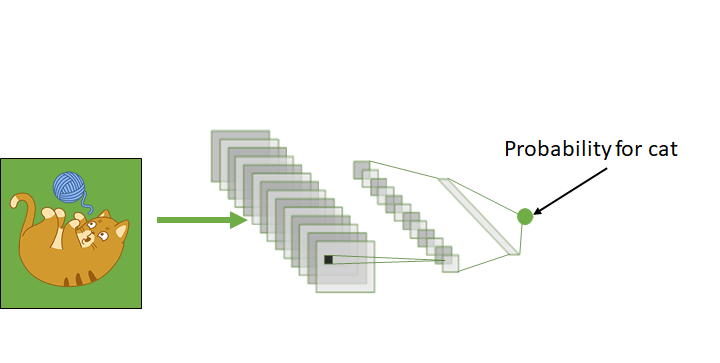

Use the same pretrained dataset to recognize dogs. 
 > * Trained on a smaller dataset
 > * During training, all layers except the output layer are “frozen”.
 > * This training procedure will take less time than the previous pre-training.
 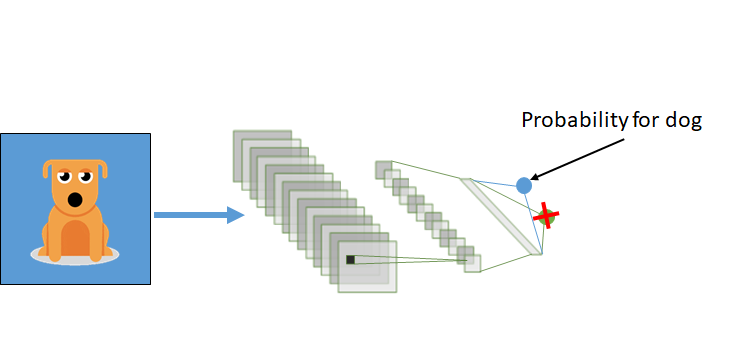

 > * Optionally the last two layers can be unfreezed, depends on the amount data we have. If we have less data, we might consider training only the last layer.

 **Transfer Learning : Fine Tuning**

 In fine tuning, we start with a pre-trained model but we update all the weights.
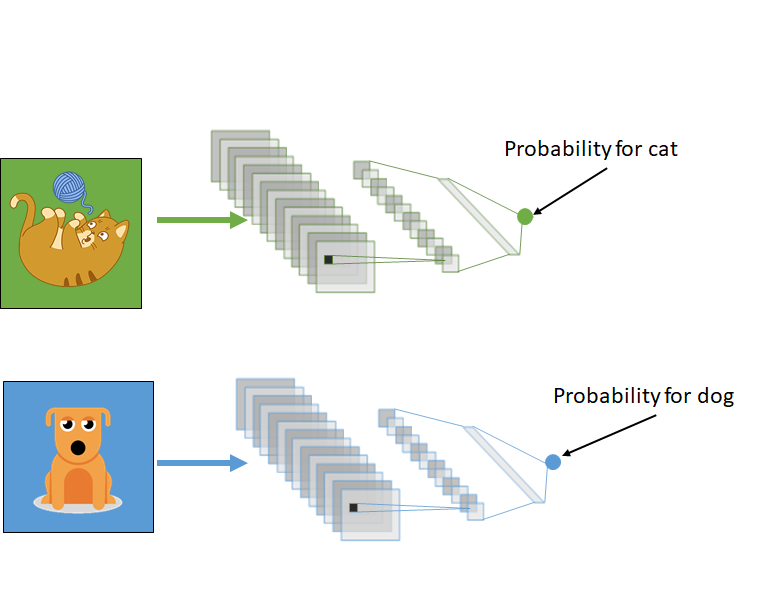

**Load data**

In [ ]:
from keras.datasets import cifar10
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


**Divide the data in Train, Validation and Test Datasets** 

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [ ]:
#Print the dataset dimensions
print('Training data :',(x_train.shape,y_train.shape))
print('Validation data :',(x_val.shape,y_val.shape))
print('Test data : ', (x_test.shape,y_test.shape))

Training data : ((35000, 32, 32, 3), (35000, 1))
Validation data : ((15000, 32, 32, 3), (15000, 1))
Test data :  ((10000, 32, 32, 3), (10000, 1))


In [ ]:
#One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
from keras.utils.np_utils import to_categorical

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [ ]:
# Lets print the dimensions one more time to see if things changed the way we expected

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


**Load VGG-16 pretrained model**

Load the pretrained VGG-16 model with Imagenet weights. Make include_top=False to make sure that we are not loading the final softmax layer.

In [ ]:
from keras.applications.vgg16 import VGG16
#Import the datagenerator to augment images'
from keras.preprocessing.image import ImageDataGenerator
vgg=VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3))

58900480/58889256 [==============================] - 0s 0us/step


**Freeze all the VGG-16 layers and train only the classifier** 

In [ ]:
for layer in vgg.layers:
   layer.trainable = False
#Now we will be training only the classifiers (FC layers)

**Add Softmax classifier** 
> Flatten the vgg lower layer output and create Dense layer with activation softmax.

> The Model class in Keras groups layers into an object with training and inference features.

>> **Arguments**

>> * inputs: The input(s) of the model: a keras.Input object or list of keras.Input objects.
>> * outputs: The output(s) of the model. See Functional API example below.

>> * name: String, the name of the model.

Click [here ](https://keras.io/api/models/model/)to know more

In [ ]:
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.models import Model
x = Flatten()(vgg.output)
#class1 = Dense(1024, activation='relu')(x)
prediction = Dense(10, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

**Compile the model**

In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

**Image augmentation and Preprocessing**

Image augmentation is done to artificially increase the number of training images our model sees by applying random transformations to the images. For example, we can randomly rotate or crop the images or flip them horizontally.


We have last argument preprocess_input ,It is meant to adequate your image to the format the model requires. It will preprocess the Image as per VGG-16.

Refer the following:

1. https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
2. https://keras.io/api/preprocessing/image/

*Keras ImageDataGenerator class  provides a quick and easy way to augment.* It is designed to provide real-time data augmentation. Meaning it is generating augmented images on the fly while your model is still in the training stage.

ImageDataGenerator class ensures that the model receives new variations of the images at each epoch. But it only returns the transformed images and does not add it to the original corpus of images.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
#Data Augmentation Function: Let's define an instance of the ImageDataGenerator class and set the parameters
# We have to instantiate for the Train,Validation and Test datasets
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

**Fit the Model**

In [ ]:
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)


**Flow_from_directory**

If you are using cutom dataset for classification you can use **flow_from_directory()** method which allows you to read the images directly from the directory and augment them while the neural network model is learning on the training data. 

The method expects that images belonging to different classes are present in different folders but are inside the same parent folder. 

Refer: https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

**Keras Fit_generator Method**

* The first argument is the iterator for the train images that we get from the flow() or flow_from_dataframe() or flow_from_directory() method.
* Epochs are the number of forward/backward passes of the training data.
* Steps_per_epoch is an important argument. It specifies the number of batches of images that are in a single epoch. It is usually taken as the length of the original dataset divided by the batch size.
* Validation_data takes the validation dataset or the validation generator output from the generator method.
* Validation_steps is similar to steps_per_epoch, but for validation data. This can be used when you are augmenting the validation set images as well.

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


batch_size=100
epochs=10
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
                      callbacks=callbacks,verbose=1)   # validation_steps=250,


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


350/350 [==============================] - ETA: 0s - loss: 0.9880 - accuracy: 0.3733
Epoch 1: val_loss improved from inf to 0.60897, saving model to mymodel.h5
350/350 [==============================] - 482s 1s/step - loss: 0.9880 - accuracy: 0.3733 - val_loss: 0.6090 - val_accuracy: 0.4433
Epoch 2/10
350/350 [==============================] - ETA: 0s - loss: 0.4502 - accuracy: 0.4800
Epoch 2: val_loss improved from 0.60897 to 0.34868, saving model to mymodel.h5
350/350 [==============================] - 477s 1s/step - loss: 0.4502 - accuracy: 0.4800 - val_loss: 0.3487 - val_accuracy: 0.5079
Epoch 3/10
350/350 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.5307
Epoch 3: val_loss improved from 0.34868 to 0.26231, saving model to mymodel.h5
350/350 [==============================] - 469s 1s/step - loss: 0.2871 - accuracy: 0.5307 - val_loss: 0.2623 - val_accuracy: 0.5344
Epoch 4/10
350/350 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.548

KeyboardInterrupt: ignored

EXPERIMENT

Select any image claasification dataset from https://archive.ics.uci.edu/ml/datasets.php. Develop a classification model using transfer learning for 2 CNN architectures.

1. VGG 19
2. ResNet50
3. ResNet101
4. InceptionV3
5. InceptionResNetV2
6. MobileNet
7. MobileNetV2
8. DenseNet121
9. Xception

 Refer Keras [Applications](https://keras.io/api/applications/) to know more about the afore-mentioned pretrained models. 

 **model1: rollnumber(mod 9) +1**
 
 **model2: Any architecture of your choice**
